# RNN Evaluation

In [1]:
import sys
import os
from pathlib import Path

wd = Path(os.path.dirname(os.path.abspath("__file__"))).parent.resolve()
sys.path.append(str(wd))

import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm
from datetime import datetime, timedelta
from prediction_engine.model import AuctionPredictor
from prediction_engine.inference import predict_dataframe

pd.options.display.max_columns = None
pd.options.display.width = None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
prediction_time = datetime.strptime("2024-10-12 00:00:00", "%Y-%m-%d %H:%M:%S")

items = pd.read_csv('../data/items.csv')
print("Items shape:", items.shape)

n_items = len(items)
item_to_index = {item_id: i + 2 for i, item_id in enumerate(items['item_id'])}
item_to_index[0] = 0
item_to_index[1] = 1
print(f"Number of unique items: {n_items}")

time_left_mapping = {
    'VERY_LONG': 48,
    'LONG': 12,
    'MEDIUM': 2,
    'SHORT': 0.5
}

Items shape: (11655, 13)
Number of unique items: 11655


In [3]:
def load_auctions_from_sample(data_dir, prediction_time):
    file_info = {}
    auction_appearances = {}

    for root, dirs, files in os.walk(data_dir):
        for filename in tqdm(files):
            filepath = os.path.join(root, filename)
            date = datetime.strptime(filename.split('.')[0], '%Y%m%dT%H')
            file_info[filepath] = date

    file_info = {k: v for k, v in sorted(file_info.items(), key=lambda item: item[1])}
    
    raw_auctions = []
    
    for filepath in list(file_info.keys()):
        with open(filepath, 'r') as f:
            try:
                json_data = json.load(f)
                
                if 'auctions' not in json_data:
                    print(f"File {filepath} does not contain 'auctions' key, skipping.")
                    continue
                
                auction_data = json_data['auctions']
                timestamp = file_info[filepath]
                
                for auction in auction_data:
                    auction_id = auction['id']

                    if auction_id not in auction_appearances:
                        auction_appearances[auction_id] = {'first': timestamp, 'last': timestamp}
                    else:
                        auction_appearances[auction_id]['last'] = timestamp
                
                if prediction_time is not None:
                    if timestamp == prediction_time:
                        raw_auctions.extend(auction_data)
                else:
                    raw_auctions.extend(auction_data)

            except json.JSONDecodeError as e:
                print(f"Error loading file {filepath}: {e}")
                continue
            except Exception as e:
                print(f"Unexpected error loading file {filepath}: {e}")
                continue

    auctions = []
    for auction in tqdm(raw_auctions):
        first_appearance = auction_appearances[auction['id']]['first']
        last_appearance = auction_appearances[auction['id']]['last']

        auctions.append([
            auction['id'],
            auction['item']['id'],
            auction['bid'] / 10000.0,
            auction['buyout'] / 10000.0,
            auction['quantity'],
            auction['time_left'],
            first_appearance.strftime('%Y-%m-%d %H:%M:%S'),
            last_appearance.strftime('%Y-%m-%d %H:%M:%S')
        ])
        
    df_auctions = pd.DataFrame(auctions, columns=['id', 'item_id', 'bid', 'buyout', 'quantity', 'time_left', 'first_appearance', 'last_appearance'])
    df_auctions['first_appearance'] = pd.to_datetime(df_auctions['first_appearance'])
    df_auctions['last_appearance'] = pd.to_datetime(df_auctions['last_appearance'])

    df_auctions = df_auctions[(df_auctions['first_appearance'] <= prediction_time) & (df_auctions['last_appearance'] >= prediction_time)]

    df_auctions['hours_since_first_appearance'] = (prediction_time - df_auctions['first_appearance']).dt.total_seconds() / 3600
    df_auctions['hours_on_sale'] = (df_auctions['last_appearance'] - prediction_time).dt.total_seconds() / 3600

    return df_auctions

data_dir = '../data/sample/'

df_auctions = load_auctions_from_sample(data_dir, prediction_time)
df_items = pd.read_csv('../data/items.csv')

df_auctions = df_auctions.merge(df_items, left_on='item_id', right_on='item_id', how='left')

print("Auctions shape:", df_auctions.shape)
df_auctions.head()

0it [00:00, ?it/s]
100%|██████████| 6302/6302 [00:00<00:00, 99211.43it/s]

Auctions shape: (6302, 22)


,id,item_id,bid,buyout,quantity,time_left,first_appearance,last_appearance,hours_since_first_appearance,hours_on_sale,item_name,quality,item_level,required_level,item_class,item_subclass,purchase_price_gold,purchase_price_silver,sell_price_gold,sell_price_silver,max_count,is_stackable
0,1408614535,15279,9.5000,10.0000,1,SHORT,2024-10-10 01:00:00,2024-10-12 02:00:00,47.0,2.0,Ivory Wand,Uncommon,51.0,46.0,Weapon,Wand,9.0,13.0,1.0,82.0,0.0,0.0
1,1408614543,15294,42.7500,45.0000,1,SHORT,2024-10-10 01:00:00,2024-10-12 02:00:00,47.0,2.0,Siege Bow,Uncommon,53.0,48.0,Weapon,Bow,10.0,6.0,2.0,1.0,0.0,0.0
2,1408614547,10070,42.7500,45.0000,1,SHORT,2024-10-10 01:00:00,2024-10-12 02:00:00,47.0,2.0,Righteous Armor,Uncommon,55.0,50.0,Armor,Leather,7.0,74.0,1.0,54.0,0.0,0.0
3,1408614554,10075,42.7500,45.0000,1,SHORT,2024-10-10 01:00:00,2024-10-12 02:00:00,47.0,2.0,Righteous Spaulders,Uncommon,51.0,46.0,Armor,Leather,4.0,68.0,0.0,93.0,0.0,0.0
4,1408614562,10078,42.7501,45.0001,1,SHORT,2024-10-10 01:00:00,2024-10-12 02:00:00,47.0,2.0,Lord's Crest,Uncommon,53.0,48.0,Armor,Shield,9.0,32.0,1.0,86.0,0.0,0.0


In [4]:
df_auctions[['hours_since_first_appearance', 'hours_on_sale']].describe()

,hours_since_first_appearance,hours_on_sale
count,6302.000000,6302.000000
mean,22.865757,20.035386
std,15.159400,14.166070
min,0.000000,0.000000
25%,10.000000,9.000000
50%,24.000000,18.000000
75%,34.000000,25.000000
max,48.000000,50.000000


In [6]:
model = AuctionPredictor(
    n_items=len(item_to_index),             
    input_size=5,                   
    encoder_hidden_size=2048,
    decoder_hidden_size=2048,
    num_layers=3,
    item_index=3,                   
    embedding_size=1024,
    dropout_p=0.2,
    bidirectional=False
).to(device)

print(f'Number of model parameters: {sum(p.numel() for p in model.parameters())}')

model_path = '../models/gru_156M.pt'
checkpoint = torch.load(model_path, map_location=device)

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  
print('Pre-trained RNN model loaded successfully.')

Number of model parameters: 156746753
Pre-trained RNN model loaded successfully.


In [7]:
df_auctions = predict_dataframe(model, df_auctions, prediction_time, time_left_mapping, item_to_index, device=device)

print("Mean hours on sale:", df_auctions['hours_on_sale'].mean())
print("Mean prediction:", df_auctions['prediction'].mean())
print("Mean sale probability:", df_auctions['sale_probability'].mean())

df_auctions.head()

100%|██████████| 1302/1302 [00:15<00:00, 81.99it/s] 

Mean hours on sale: 20.035385591875595
Mean prediction: 19.330182481751823
Mean sale probability: 0.51416477957295


,id,item_id,bid,buyout,quantity,time_left,first_appearance,last_appearance,hours_since_first_appearance,hours_on_sale,item_name,quality,item_level,required_level,item_class,item_subclass,purchase_price_gold,purchase_price_silver,sell_price_gold,sell_price_silver,max_count,is_stackable,prediction,sale_probability
0,1408614535,15279,9.5000,10.0000,1,SHORT,2024-10-10 01:00:00,2024-10-12 02:00:00,47.0,2.0,Ivory Wand,Uncommon,51.0,46.0,Weapon,Wand,9.0,13.0,1.0,82.0,0.0,0.0,1.39,0.945849
1,1408614543,15294,42.7500,45.0000,1,SHORT,2024-10-10 01:00:00,2024-10-12 02:00:00,47.0,2.0,Siege Bow,Uncommon,53.0,48.0,Weapon,Bow,10.0,6.0,2.0,1.0,0.0,0.0,1.61,0.937594
2,1408614547,10070,42.7500,45.0000,1,SHORT,2024-10-10 01:00:00,2024-10-12 02:00:00,47.0,2.0,Righteous Armor,Uncommon,55.0,50.0,Armor,Leather,7.0,74.0,1.0,54.0,0.0,0.0,1.81,0.930138
3,1408614554,10075,42.7500,45.0000,1,SHORT,2024-10-10 01:00:00,2024-10-12 02:00:00,47.0,2.0,Righteous Spaulders,Uncommon,51.0,46.0,Armor,Leather,4.0,68.0,0.0,93.0,0.0,0.0,1.77,0.931440
4,1408614562,10078,42.7501,45.0001,1,SHORT,2024-10-10 01:00:00,2024-10-12 02:00:00,47.0,2.0,Lord's Crest,Uncommon,53.0,48.0,Armor,Shield,9.0,32.0,1.0,86.0,0.0,0.0,1.83,0.929165


In [8]:
mae = mean_absolute_error(df_auctions['hours_on_sale'], df_auctions['prediction'])
print(f"Mean absolute error: {mae}")

Mean absolute error: 4.134457315138052


## Error analysis

In [9]:
columns = [
    'item_name',
    'bid',
    'buyout',
    'quantity',
    'time_left',
    'first_appearance',
    'last_appearance',
    'hours_since_first_appearance',
    'hours_on_sale',
    'prediction',
    'sale_probability'
]

df_error = df_auctions[columns].copy()
df_error['error'] = np.abs(df_error['hours_on_sale'] - df_error['prediction'])
df_error['time_left'] = df_error['time_left'].map(time_left_mapping)

df_error.head()

,item_name,bid,buyout,quantity,time_left,first_appearance,last_appearance,hours_since_first_appearance,hours_on_sale,prediction,sale_probability,error
0,Ivory Wand,9.5000,10.0000,1,0.5,2024-10-10 01:00:00,2024-10-12 02:00:00,47.0,2.0,1.39,0.945849,0.61
1,Siege Bow,42.7500,45.0000,1,0.5,2024-10-10 01:00:00,2024-10-12 02:00:00,47.0,2.0,1.61,0.937594,0.39
2,Righteous Armor,42.7500,45.0000,1,0.5,2024-10-10 01:00:00,2024-10-12 02:00:00,47.0,2.0,1.81,0.930138,0.19
3,Righteous Spaulders,42.7500,45.0000,1,0.5,2024-10-10 01:00:00,2024-10-12 02:00:00,47.0,2.0,1.77,0.931440,0.23
4,Lord's Crest,42.7501,45.0001,1,0.5,2024-10-10 01:00:00,2024-10-12 02:00:00,47.0,2.0,1.83,0.929165,0.17


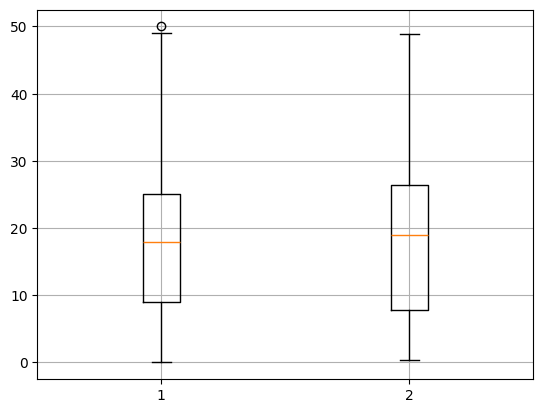

In [10]:
plt.boxplot(df_error[['hours_on_sale', 'prediction']])
plt.grid()
plt.show()

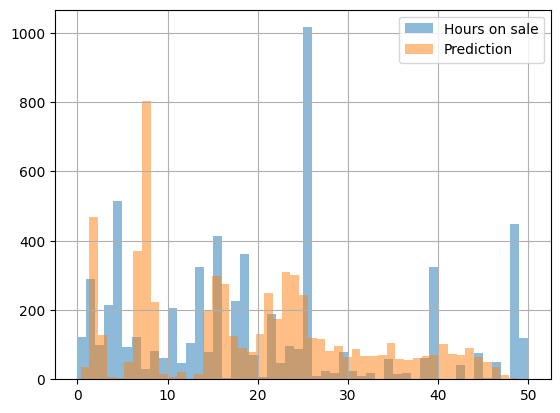

In [11]:
# histogram of hours on sale and prediction
plt.hist(df_error['hours_on_sale'], bins=50, alpha=0.5, label='Hours on sale')
plt.hist(df_error['prediction'], bins=50, alpha=0.5, label='Prediction')
plt.legend(loc='upper right')
plt.grid()
plt.show()

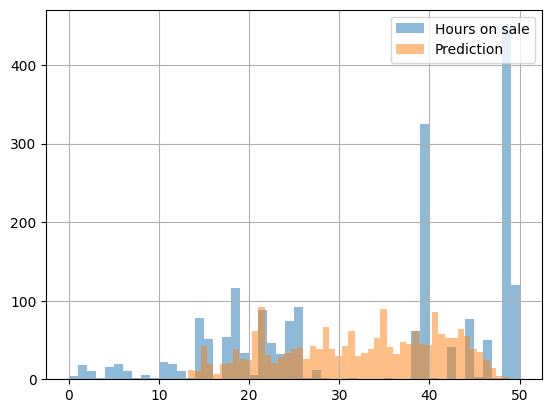

In [12]:
plt.hist(df_error[(df_error['time_left'] == 48.0) & (df_error['hours_since_first_appearance'] < 12)]['hours_on_sale'], bins=50, alpha=0.5, label='Hours on sale')
plt.hist(df_error[(df_error['time_left'] == 48.0) & (df_error['hours_since_first_appearance'] < 12)]['prediction'], bins=50, alpha=0.5, label='Prediction')
plt.legend(loc='upper right')
plt.grid()
plt.show()

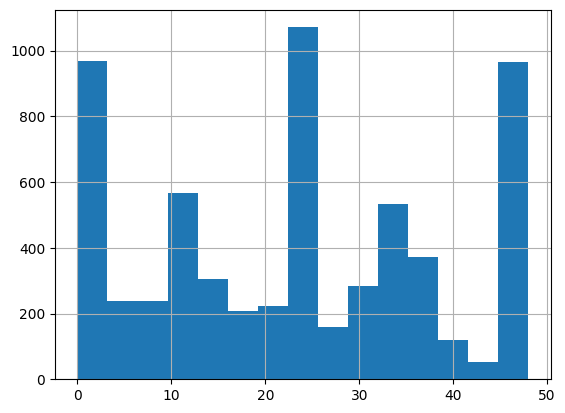

In [13]:
plt.hist(df_error['hours_since_first_appearance'], bins=15)
plt.grid()
plt.show()

In [14]:
print(df_error[df_error['hours_on_sale'] <= 10].error.mean())
df_error[df_error['hours_on_sale'] <= 10].sample(10)

3.2000874794969936


,item_name,bid,buyout,quantity,time_left,first_appearance,last_appearance,hours_since_first_appearance,hours_on_sale,prediction,sale_probability,error
48,Silk Cloth,2.8386,2.9880,1,2.0,2024-10-10 01:00:00,2024-10-12 02:00:00,47.0,2.0,3.05,0.884884,1.05
4493,Lesser Moonstone,0.3762,0.3959,1,48.0,2024-10-11 16:00:00,2024-10-12 10:00:00,8.0,10.0,20.62,0.437352,10.62
231,Glyph of Innervate,111.9899,111.9899,1,12.0,2024-10-10 03:00:00,2024-10-12 04:00:00,45.0,4.0,7.39,0.743479,3.39
80,Mystic Amberjewel,100.4893,105.7782,1,2.0,2024-10-10 02:00:00,2024-10-12 03:00:00,46.0,3.0,2.02,0.922143,0.98
393,Glyph of Power Word: Shield,58.7699,58.7699,1,12.0,2024-10-10 03:00:00,2024-10-12 04:00:00,45.0,4.0,5.98,0.786640,1.98
398,Glyph of Ice Block,554.9999,554.9999,1,12.0,2024-10-10 03:00:00,2024-10-12 04:00:00,45.0,4.0,7.89,0.728707,3.89
589,Glyph of Mind Flay,150.9992,150.9992,1,12.0,2024-10-10 03:00:00,2024-10-12 04:00:00,45.0,4.0,6.27,0.777589,2.27
3476,Brilliant Inferno Ruby,138.0000,139.8875,1,12.0,2024-10-11 05:00:00,2024-10-12 02:00:00,19.0,2.0,6.45,0.772070,4.45
3695,Mithril Ore,18.9164,19.9120,20,12.0,2024-10-11 09:00:00,2024-10-12 10:00:00,15.0,10.0,7.45,0.741773,2.55
74,Mystic Amberjewel,100.4893,105.7782,1,2.0,2024-10-10 02:00:00,2024-10-12 03:00:00,46.0,3.0,2.03,0.921780,0.97


In [18]:
print(df_error[df_error['hours_on_sale'] > 30].error.mean())
df_error[df_error['hours_on_sale'] > 30].sample(10)

7.270264


,item_name,bid,buyout,quantity,time_left,first_appearance,last_appearance,hours_since_first_appearance,hours_on_sale,prediction,sale_probability,error
4642,Copper Bar,18.9962,19.9960,20,48.0,2024-10-11 17:00:00,2024-10-13 18:00:00,7.0,42.0,19.02,0.466421,22.98
5696,Ravencrest Legplates,47.5000,50.0000,1,48.0,2024-10-11 23:00:00,2024-10-14 00:00:00,1.0,48.0,32.02,0.276877,15.98
4392,Glyph of Lightning Bolt,4.9997,4.9997,1,48.0,2024-10-11 14:00:00,2024-10-13 15:00:00,10.0,39.0,31.31,0.284975,7.69
6163,Glyph of Earthliving Weapon,261.0150,262.0000,1,48.0,2024-10-12 00:00:00,2024-10-14 01:00:00,0.0,49.0,42.26,0.183663,6.74
4440,Glyph of Renew,22.6598,22.6598,1,48.0,2024-10-11 14:00:00,2024-10-13 15:00:00,10.0,39.0,28.61,0.317477,10.39
5635,Glyph of Avenger's Shield,554.0150,555.0000,1,48.0,2024-10-11 23:00:00,2024-10-14 00:00:00,1.0,48.0,47.34,0.149840,0.66
5307,Smooth Amberjewel,179.2592,188.6938,1,48.0,2024-10-11 23:00:00,2024-10-13 22:00:00,1.0,46.0,31.63,0.281252,14.37
6157,Glyph of Renewed Life,551.0150,552.0000,1,48.0,2024-10-12 00:00:00,2024-10-14 01:00:00,0.0,49.0,43.45,0.175119,5.55
5113,Glyph of Searing Pain,27.4432,28.8875,1,48.0,2024-10-11 23:00:00,2024-10-14 00:00:00,1.0,48.0,43.14,0.177276,4.86
3671,Linen Cloth,3.7867,3.9860,20,48.0,2024-10-11 09:00:00,2024-10-13 10:00:00,15.0,34.0,20.35,0.442195,13.65


We are interested in evaluating the model when the items are recently published, because this will be the main use case for the model

In [ ]:
query = (df_error['hours_since_first_appearance'] <= 3) & (df_error['hours_on_sale'] <= 12) & (df_error['time_left'] == 48.0)
query_df = df_error[query]
print(f"Mean sale probability: {query_df['sale_probability'].mean()}")
print(f"Mean error: {query_df['error'].mean()}")
print(f"Mean hours on sale: {query_df['hours_on_sale'].mean()}")
query_df.sample(10)


Mean sale probability: 0.4413790660532085
Mean error: 14.92774193548387
Mean hours on sale: 6.354838709677419


,item_name,bid,buyout,quantity,time_left,first_appearance,last_appearance,hours_since_first_appearance,hours_on_sale,prediction,sale_probability,error
4962,Light Leather,8.0450,8.2107,20,48.0,2024-10-11 21:00:00,2024-10-12 02:00:00,3.0,2.0,24.97,0.367436,22.97
6127,Super Rejuvenation Potion,1.0000,1.0000,2,48.0,2024-10-11 23:00:00,2024-10-12 01:00:00,1.0,1.0,37.64,0.221045,36.64
4972,Iron Ore,0.4500,8.0000,20,48.0,2024-10-11 21:00:00,2024-10-12 05:00:00,3.0,5.0,21.17,0.427948,16.17
4997,Mana Potion,0.6169,0.6493,1,48.0,2024-10-11 22:00:00,2024-10-12 11:00:00,2.0,11.0,15.73,0.532113,4.73
6150,Wool Cloth,8.9869,8.9969,20,48.0,2024-10-12 00:00:00,2024-10-12 04:00:00,0.0,4.0,15.39,0.539527,11.39
4978,Silk Cloth,1.1968,1.2597,1,48.0,2024-10-11 22:00:00,2024-10-12 12:00:00,2.0,12.0,13.25,0.587759,1.25
6133,Linen Cloth,2.0000,2.0069,20,48.0,2024-10-12 00:00:00,2024-10-12 07:00:00,0.0,7.0,15.21,0.543377,8.21
5016,Runecloth,2.6388,2.7776,2,48.0,2024-10-11 22:00:00,2024-10-12 08:00:00,2.0,8.0,18.54,0.475482,10.54
5750,Lesser Moonstone,0.3760,0.3957,1,48.0,2024-10-11 23:00:00,2024-10-12 10:00:00,1.0,10.0,22.62,0.403682,12.62
4992,Runecloth,15.0800,25.0000,18,48.0,2024-10-11 22:00:00,2024-10-12 08:00:00,2.0,8.0,18.16,0.482790,10.16


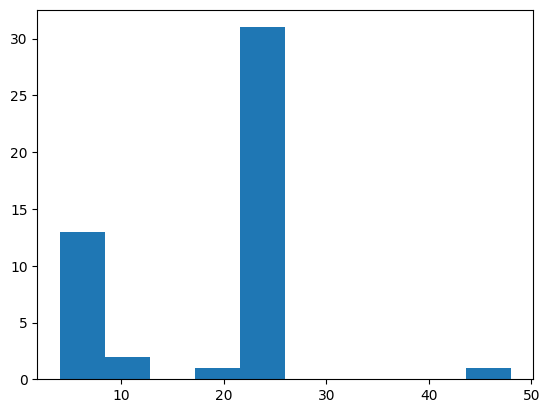

In [74]:
query_df['hours_on_sale'].hist(bins=10)
plt.grid()
plt.show()

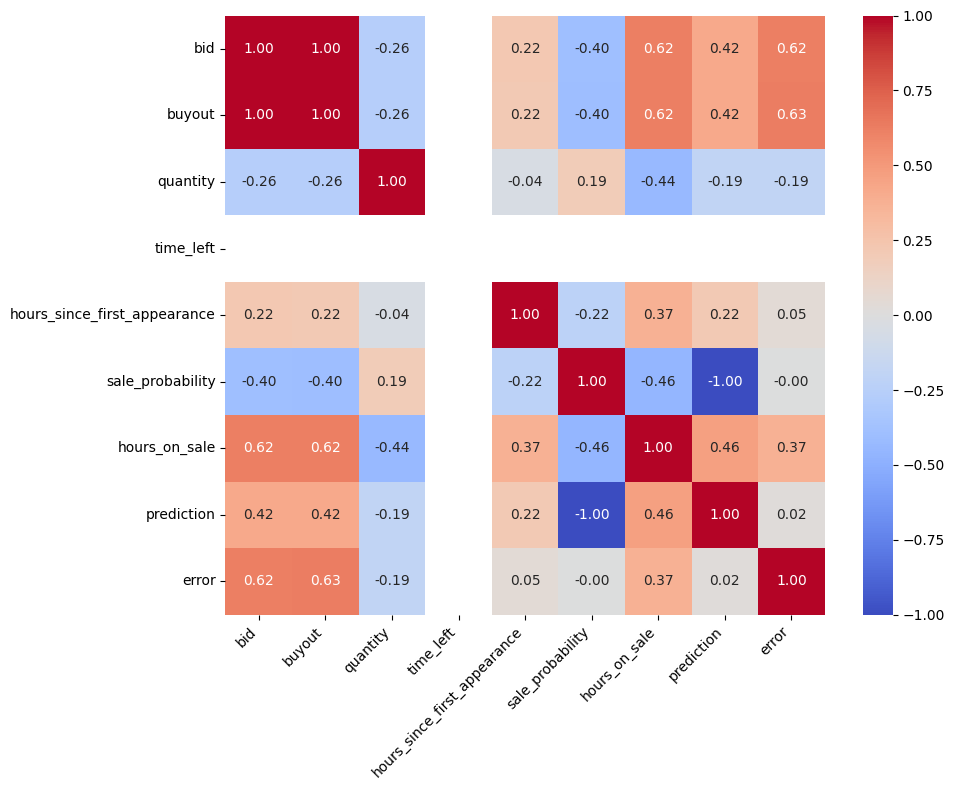

In [ ]:
corr_matrix = df_error[['bid', 'buyout', 'quantity', 'time_left', 'hours_since_first_appearance', 'sale_probability',
                        'hours_on_sale', 'prediction', 'error']].corr()

plt.figure(figsize=(10, 8))

sns.heatmap(corr_matrix, 
            annot=True, 
            cmap='coolwarm',
            vmin=-1, vmax=1, 
            center=0,
            fmt='.2f',
            square=True) 

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()

plt.show()

In [17]:
df_error.to_csv('../generated/predictions.csv', index=False)